<a href="https://colab.research.google.com/github/fxlmer/JSTP22_Skin-Diseases-Classification-Using-Machine-Learning/blob/master/Ex1_HAM10000_ResNet50_Ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [ ]:
!nvidia-smi

Sat Feb 20 08:04:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from ham10000_6classes_utils_functions_Ver2 import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [ ]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 6

LR = 1e-5 # Learning rate

# Data Preparation

In [ ]:
!git clone https://github.com/EvilPickle-PCSHSPT/6_classes_HAM10000_split_Ver2

fatal: destination path '6_classes_HAM10000_split_Ver2' already exists and is not an empty directory.


In [ ]:
train_path = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train' 
val_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_val'
test_path = '/content/6_classes_HAM10000_split_Ver2/images/cc_test'

# Data Augmentation

In [ ]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 4160 images belonging to 6 classes.
Found 896 images belonging to 6 classes.
Found 334 images belonging to 6 classes.


# Model

## Build Model

In [ ]:
def build_model_ResNet50():
  base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(average_pooling_layer)
  model = Model(inputs=base_model.input, outputs=prediction_layer)
  return model

In [ ]:
model = build_model_ResNet50()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [ ]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='Ex1_HAM10000_ResNet50_Ver2_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [ ]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
130/130 [==============================] - ETA: 0s - batch: 64.5000 - size: 32.0000 - loss: 1.5587 - accuracy: 0.4195

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


130/130 [==============================] - 93s 573ms/step - batch: 64.5000 - size: 32.0000 - loss: 1.5587 - accuracy: 0.4195 - val_loss: 3.2948 - val_accuracy: 0.3359
Epoch 2/100
130/130 [==============================] - 54s 414ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.9743 - accuracy: 0.6305 - val_loss: 4.1065 - val_accuracy: 0.3359
Epoch 3/100
130/130 [==============================] - 58s 444ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.7938 - accuracy: 0.6954 - val_loss: 3.2746 - val_accuracy: 0.3359
Epoch 4/100
130/130 [==============================] - 57s 440ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.6632 - accuracy: 0.7546 - val_loss: 2.1954 - val_accuracy: 0.3326
Epoch 5/100
130/130 [==============================] - 57s 440ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.6000 - accuracy: 0.7728 - val_loss: 2.1574 - val_accuracy: 0.3069
Epoch 6/100
130/130 [==============================] - 57s 439ms/step - batch: 64.5000 - size: 32.0000 - loss: 0.5185

# Training Graph

## Accuracy

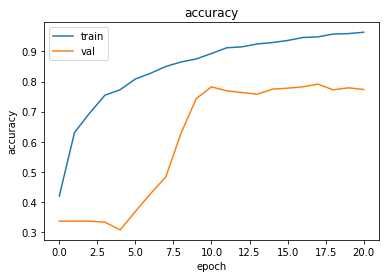

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

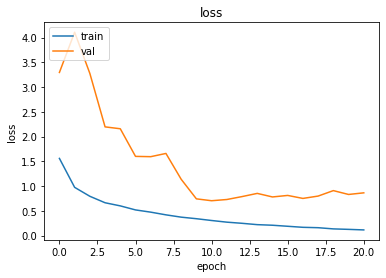

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [ ]:
test_model = tf.keras.models.load_model('/content/Ex1_HAM10000_ResNet50_Ver2_model.h5')

In [ ]:
num_test_files = len(test_generator.filenames)

In [ ]:
test_generator.reset()

In [ ]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix


### Without Normalize

Confusion matrix, without normalization
[[18  5  7  1  2  0]
 [ 2 42  3  2  3  0]
 [ 2  4 85  3 16  0]
 [ 0  2  0  9  1  0]
 [ 3  3 10  0 96  0]
 [ 0  1  1  0  0 13]]


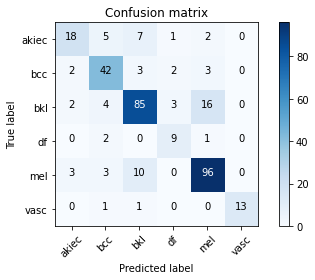

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'vasc']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[0.54545455 0.15151515 0.21212121 0.03030303 0.06060606 0.        ]
 [0.03846154 0.80769231 0.05769231 0.03846154 0.05769231 0.        ]
 [0.01818182 0.03636364 0.77272727 0.02727273 0.14545455 0.        ]
 [0.         0.16666667 0.         0.75       0.08333333 0.        ]
 [0.02678571 0.02678571 0.08928571 0.         0.85714286 0.        ]
 [0.         0.06666667 0.06666667 0.         0.         0.86666667]]


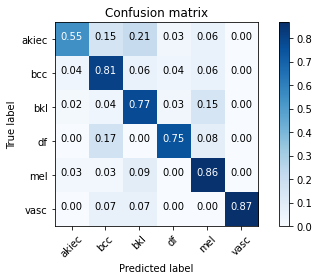

In [ ]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [ ]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[18  5  7  1  2  0]
 [ 2 42  3  2  3  0]
 [ 2  4 85  3 16  0]
 [ 0  2  0  9  1  0]
 [ 3  3 10  0 96  0]
 [ 0  1  1  0  0 13]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.72      0.55      0.62        33
         bcc       0.74      0.81      0.77        52
         bkl       0.80      0.77      0.79       110
          df       0.60      0.75      0.67        12
         mel       0.81      0.86      0.83       112
        vasc       1.00      0.87      0.93        15

    accuracy                           0.79       334
   macro avg       0.78      0.77      0.77       334
weighted avg       0.79      0.79      0.79       334



## TP FP FN TN

In [ ]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [ ]:
TruePositive= np.diag(cm_2)

In [ ]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[18 42 85  9 96 13]
Sum of True Positive:  263


### FP

In [ ]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [ ]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[7, 15, 21, 6, 22, 0]
Sum of False Positive:  71


### FN

In [ ]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [ ]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[15, 10, 25, 3, 16, 2]
Sum of False Negative:  71


### TN

In [ ]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [ ]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[294, 267, 203, 316, 200, 319]
Sum of True Negative:  1599


## Check TP + FP + FN + TN = Test set

In [ ]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True
True
True
True
True


## PYCM

In [ ]:
!pip3 install pycm==3.0 

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 573kB 7.2MB/s 


In [ ]:
from pycm import *

In [ ]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [ ]:
py_cm.classes

[0, 1, 2, 3, 4, 5]

In [ ]:
py_cm.table

{0: {0: 18, 1: 5, 2: 7, 3: 1, 4: 2, 5: 0},
 1: {0: 2, 1: 42, 2: 3, 3: 2, 4: 3, 5: 0},
 2: {0: 2, 1: 4, 2: 85, 3: 3, 4: 16, 5: 0},
 3: {0: 0, 1: 2, 2: 0, 3: 9, 4: 1, 5: 0},
 4: {0: 3, 1: 3, 2: 10, 3: 0, 4: 96, 5: 0},
 5: {0: 0, 1: 1, 2: 1, 3: 0, 4: 0, 5: 13}}

In [ ]:
print(py_cm)

Predict  0        1        2        3        4        5        
Actual
0        18       5        7        1        2        0        

1        2        42       3        2        3        0        

2        2        4        85       3        16       0        

3        0        2        0        9        1        0        

4        3        3        10       0        96       0        

5        0        1        1        0        0        13       





Overall Statistics : 

95% CI                                                            (0.74355,0.8313)
ACC Macro                                                         0.92914
ARI                                                               0.53959
AUNP                                                              0.85604
AUNU                                                              0.85931
Bangdiwala B                                                      0.64666
Bennett S                                                  

### Average AUC

In [ ]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1] + py_cm.AUC[2] + py_cm.AUC[3] + py_cm.AUC[4] + py_cm.AUC[5])/len(py_cm.AUC)

In [ ]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.8593128089080575


### Average Sensitivity

In [ ]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1] + py_cm.TPR[2] + py_cm.TPR[3] + py_cm.TPR[4] + py_cm.TPR[5])/len(py_cm.TPR)

In [ ]:
print('Average Sensitivity: ', AV_Sens)

Average Sensitivity:  0.7666139416139416


### Average Specificity

In [ ]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1] + py_cm.TNR[2] + py_cm.TNR[3] + py_cm.TNR[4] + py_cm.TNR[5])/len(py_cm.TNR)

In [ ]:
print('Average Specificity: ', AV_Spec)

Average Specificity:  0.9520116762021732


## Grad-CAM

In [ ]:
last_conv2d = 'conv5_block3_3_conv'

### AKIEC

In [ ]:
akiec_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/akiec/ISIC_0026492.jpg' 

Model prediction:
	mel            	(4)	with probability 0.895
	akiec          	(0)	with probability 0.079
	bkl            	(2)	with probability 0.023
	df             	(3)	with probability 0.002
	bcc            	(1)	with probability 0.001
Explanation for 'mel'


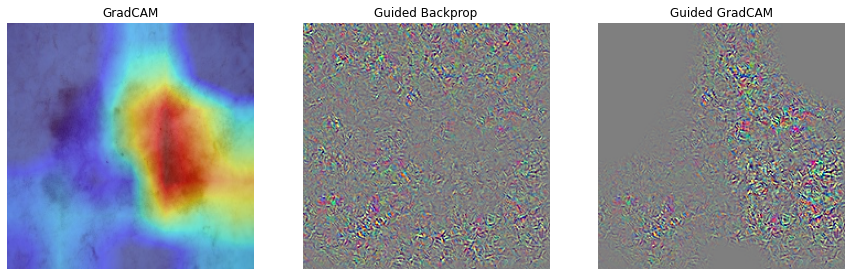

In [ ]:
 gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### BCC

In [ ]:
bcc_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bcc/ISIC_0024332.jpg'

Model prediction:
	akiec          	(0)	with probability 0.553
	mel            	(4)	with probability 0.220
	bkl            	(2)	with probability 0.125
	bcc            	(1)	with probability 0.051
	df             	(3)	with probability 0.051
Explanation for 'akiec'


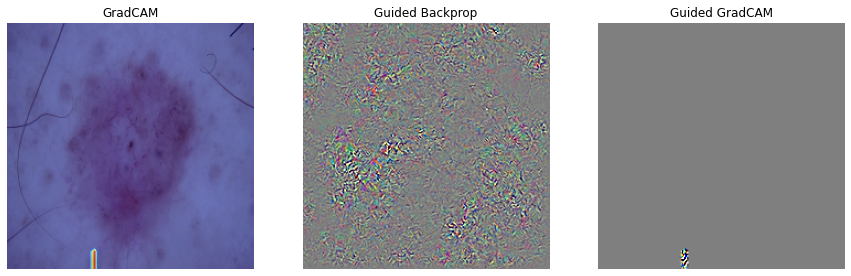

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bcc_img, layer_name=last_conv2d)

### BKL

In [ ]:
bkl_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bkl/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.974
	bkl            	(2)	with probability 0.024
	akiec          	(0)	with probability 0.002
	bcc            	(1)	with probability 0.000
	df             	(3)	with probability 0.000
Explanation for 'mel'


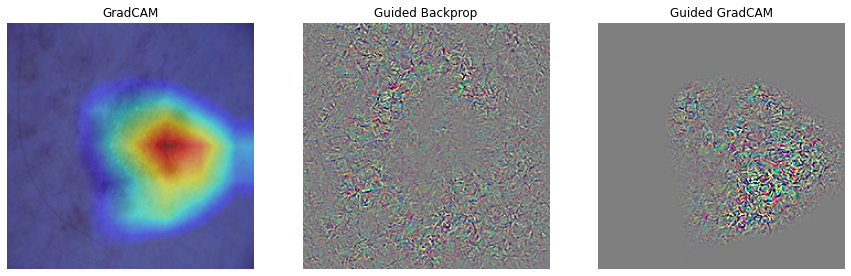

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bkl_img, layer_name=last_conv2d)

### DF

In [ ]:
df_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_val/df/ISIC_0033626.jpg'

Model prediction:
	mel            	(4)	with probability 0.670
	df             	(3)	with probability 0.322
	bkl            	(2)	with probability 0.007
	bcc            	(1)	with probability 0.000
	akiec          	(0)	with probability 0.000
Explanation for 'mel'


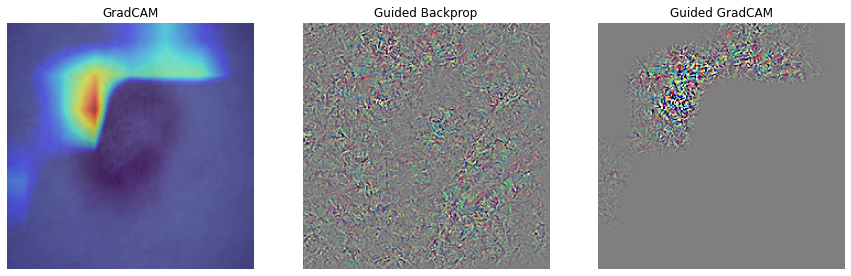

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, df_img, layer_name=last_conv2d)

### MEL

In [ ]:
mel_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/mel/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.997
	akiec          	(0)	with probability 0.003
	bkl            	(2)	with probability 0.001
	bcc            	(1)	with probability 0.000
	vasc           	(5)	with probability 0.000
Explanation for 'mel'


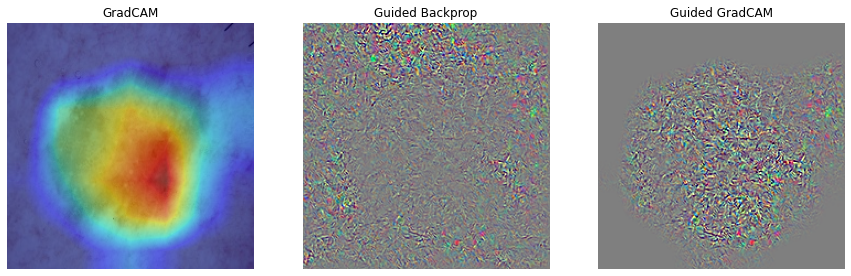

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, mel_img, layer_name=last_conv2d)

### VASC

In [ ]:
vasc_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_test/vasc/ISIC_0025452.jpg'

Model prediction:
	vasc           	(5)	with probability 0.998
	mel            	(4)	with probability 0.001
	df             	(3)	with probability 0.000
	akiec          	(0)	with probability 0.000
	bcc            	(1)	with probability 0.000
Explanation for 'vasc'


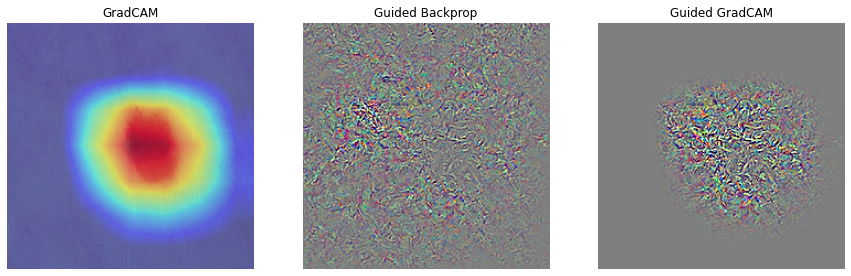

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, vasc_img, layer_name=last_conv2d)

# Download Model

In [ ]:
from google.colab import files

In [ ]:
files.download('/content/Ex1_HAM10000_ResNet50_Ver2_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>